<a href="https://colab.research.google.com/github/alwanrahmanas/forecastTraining/blob/main/NBeats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

In [65]:
!pip install ipython-autotime
%load_ext autotime

time: 454 µs (started: 2024-03-30 07:07:01 +00:00)


In [1]:
!pip install neuralforecast

# Prep

In [22]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss
from neuralforecast.tsdataset import TimeSeriesDataset
from neuralforecast.utils import AirPassengers, AirPassengersPanel, AirPassengersStatic


In [13]:
Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

# Modelling

In [42]:
model = NBEATSx(h=2, input_size=24,
                #loss=MQLoss(level=[80, 90]),
                loss=DistributionLoss(distribution='Normal', level=[80, 90]),
                scaler_type='robust',
                dropout_prob_theta=0.5,
                stat_exog_list=['airline1'],
                futr_exog_list=['trend'],
                max_steps=100,
                val_check_steps=5,
                early_stop_patience_steps=2)

nf = NeuralForecast(
    models=[model],
    freq='M'
)


INFO:lightning_fabric.utilities.seed:Seed set to 1


In [43]:
nf.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
Y_hat_df = nf.predict(futr_df=Y_test_df)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [51]:
Y_test_df

,unique_id,ds,y,trend,y_[lag12]
0,Airline1,1960-01-31,417.0,132,360.0
1,Airline1,1960-02-29,391.0,133,342.0
2,Airline1,1960-03-31,419.0,134,406.0
3,Airline1,1960-04-30,461.0,135,396.0
4,Airline1,1960-05-31,472.0,136,420.0
5,Airline1,1960-06-30,535.0,137,472.0
6,Airline1,1960-07-31,622.0,138,548.0
7,Airline1,1960-08-31,606.0,139,559.0
8,Airline1,1960-09-30,508.0,140,463.0
9,Airline1,1960-10-31,461.0,141,407.0


In [49]:
Y_hat_df

,ds,NBEATSx,NBEATSx-median,NBEATSx-lo-90,NBEATSx-lo-80,NBEATSx-hi-80,NBEATSx-hi-90
0,1960-01-31,405.498444,405.705872,387.421173,392.375977,418.860352,423.108765
1,1960-02-29,388.531433,388.578430,369.147034,373.632843,403.155609,407.568115
2,1960-01-31,706.145874,706.099243,687.562256,692.138489,720.661072,724.670105
3,1960-02-29,689.215454,689.571045,670.868347,675.345703,703.187927,706.926514


In [54]:
merged_df = pd.merge(Y_test_df, Y_hat_df, on='ds', suffixes=('_true', '_pred'))
merged_df

,unique_id,ds,y,trend,y_[lag12],NBEATSx,NBEATSx-median,NBEATSx-lo-90,NBEATSx-lo-80,NBEATSx-hi-80,NBEATSx-hi-90
0,Airline1,1960-01-31,417.0,132,360.0,405.498444,405.705872,387.421173,392.375977,418.860352,423.108765
1,Airline1,1960-01-31,417.0,132,360.0,706.145874,706.099243,687.562256,692.138489,720.661072,724.670105
2,Airline1,1960-02-29,391.0,133,342.0,388.531433,388.578430,369.147034,373.632843,403.155609,407.568115
3,Airline1,1960-02-29,391.0,133,342.0,689.215454,689.571045,670.868347,675.345703,703.187927,706.926514
4,Airline2,1960-01-31,717.0,276,660.0,405.498444,405.705872,387.421173,392.375977,418.860352,423.108765
5,Airline2,1960-01-31,717.0,276,660.0,706.145874,706.099243,687.562256,692.138489,720.661072,724.670105
6,Airline2,1960-02-29,691.0,277,642.0,388.531433,388.578430,369.147034,373.632843,403.155609,407.568115
7,Airline2,1960-02-29,691.0,277,642.0,689.215454,689.571045,670.868347,675.345703,703.187927,706.926514


In [56]:
filtered_df = merged_df[merged_df['unique_id'] != 'Airline2']
filtered_df

,unique_id,ds,y,trend,y_[lag12],NBEATSx,NBEATSx-median,NBEATSx-lo-90,NBEATSx-lo-80,NBEATSx-hi-80,NBEATSx-hi-90
0,Airline1,1960-01-31,417.0,132,360.0,405.498444,405.705872,387.421173,392.375977,418.860352,423.108765
1,Airline1,1960-01-31,417.0,132,360.0,706.145874,706.099243,687.562256,692.138489,720.661072,724.670105
2,Airline1,1960-02-29,391.0,133,342.0,388.531433,388.578430,369.147034,373.632843,403.155609,407.568115
3,Airline1,1960-02-29,391.0,133,342.0,689.215454,689.571045,670.868347,675.345703,703.187927,706.926514


# Eval

In [71]:
results_df

,RMSE,MAPE,MAE
NBEATSx,207.771622,37.249747,150.332855
NBEATSx-median,207.880051,37.254247,150.346497
NBEATSx-lo-90,195.501083,37.285715,150.465607
NBEATSx-lo-80,198.407166,37.262475,150.368835
NBEATSx-hi-80,217.843155,39.054710,157.466248
NBEATSx-hi-90,220.670731,40.070933,161.568375


time: 17.9 ms (started: 2024-03-30 07:20:15 +00:00)


In [64]:
# Find the column with the smallest value for each metric
best_rmse_column = results_df['RMSE'].idxmin()
best_mape_column = results_df['MAPE'].idxmin()
best_mae_column = results_df['MAE'].idxmin()

# Print the results
print("Column with the smallest RMSE:", best_rmse_column)
print("Column with the smallest MAPE:", best_mape_column)
print("Column with the smallest MAE:", best_mae_column)


Column with the smallest RMSE: NBEATSx-lo-90
Column with the smallest MAPE: NBEATSx
Column with the smallest MAE: NBEATSx


## Visualize

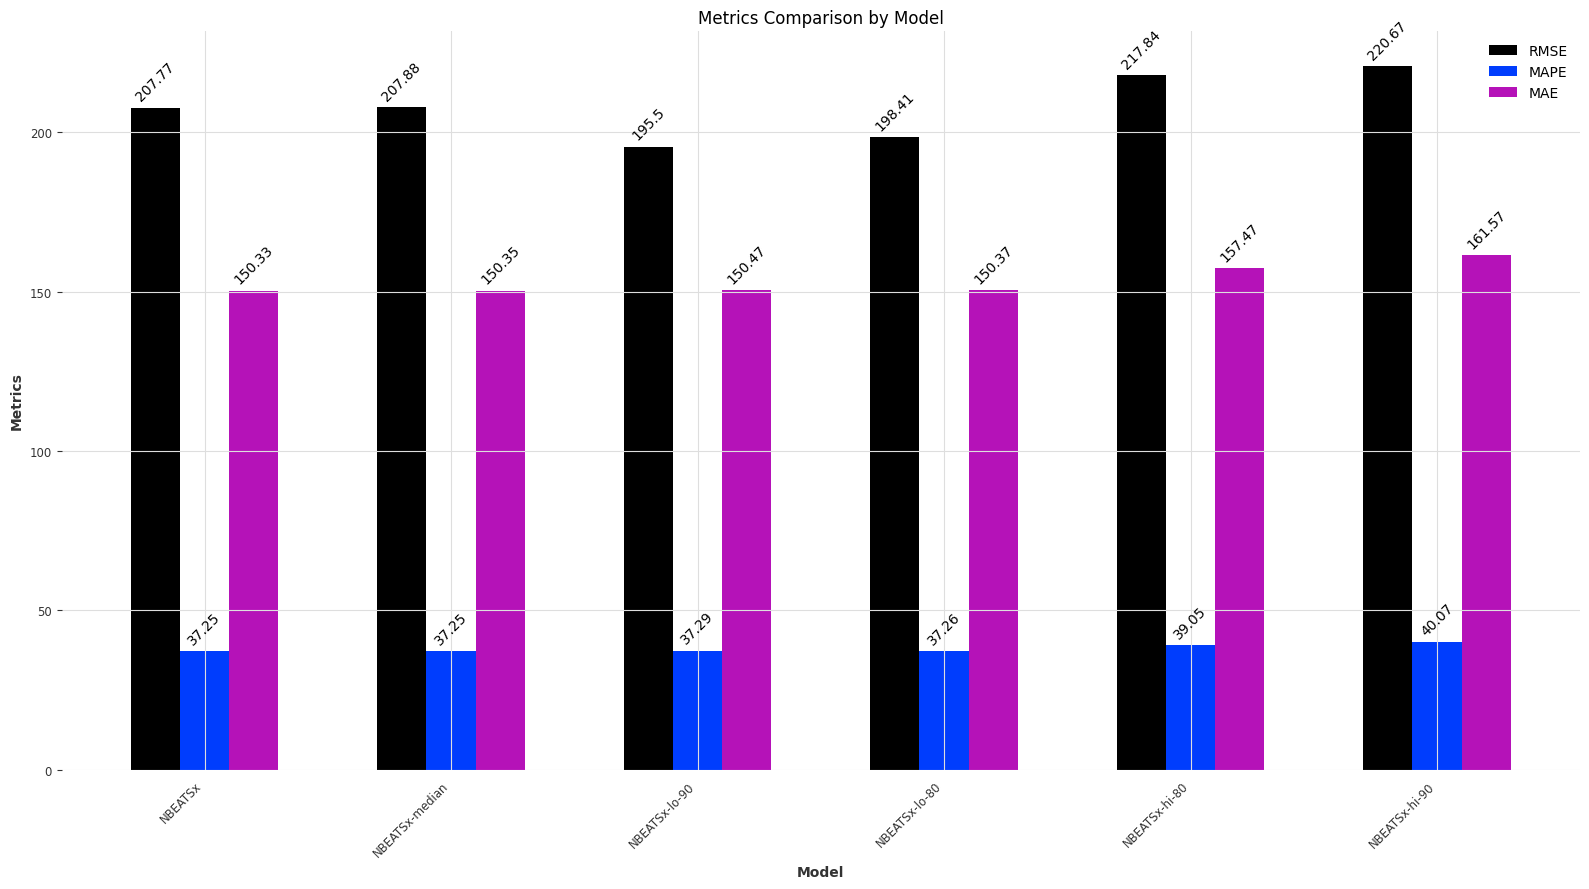

time: 547 ms (started: 2024-03-30 07:26:25 +00:00)


In [80]:
import matplotlib.pyplot as plt
import numpy as np

# Define figure and axis
fig, ax = plt.subplots(figsize=(16, 9))

# Define bar width
bar_width = 0.2

# Define positions for bars
index = np.arange(len(results_df))

# Plot bars for each metric
rects1 = ax.bar(index - bar_width, results_df['RMSE'], bar_width, label='RMSE')
rects2 = ax.bar(index, results_df['MAPE'], bar_width, label='MAPE')
rects3 = ax.bar(index + bar_width, results_df['MAE'], bar_width, label='MAE')

# Add exact values at the top of each bar with 45-degree rotation
for rects in [rects1, rects2, rects3]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=45)  # Rotate the text by 45 degrees

# Customize the plot
ax.set_xlabel('Model')
ax.set_ylabel('Metrics')
ax.set_title('Metrics Comparison by Model')
ax.set_xticks(index)
ax.set_xticklabels(results_df.index, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()
